# Transfer Learning with MobileNetV2

This notebook is adapted from Deeplearning.ai's online course, Deep Learning.

In this notebook, transfer learning will be used on a pre-trained CNN to build a binary Alpaca classifier.

A pre-trained model is a network that has already been trained on a large dataset and saved, enabling it to be customized efficiently and cost-effectively. The pre-trained model used in this notebook, MobileNetV2, is designed for fast and computationally efficient performance. It has been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

**Objectives:**

- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNetV2
- Fine-tune the classifier's final layers to improve accuracy

In [ ]:
# uncomment the following line to install the packages.
# !pip install numpy matplotlib tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### Create the Dataset and Split it into Training and Validation Sets

Training and evaluating deep learning models in Keras with image files stored on disk is simple and efficient. To create training and validation datasets from image files, use the `image_data_set_from_directory()` function.

When specifying a validation split, indicate the subset for each portion by setting `subset='training'` for the training set and `subset='validation'` for the validation set.

Ensure that the seeds match for both sets to prevent overlap between the training and validation data.


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Now let's take a look at some of the images from the training set: 

**Note:** The original dataset has some mislabelled images in it as well.

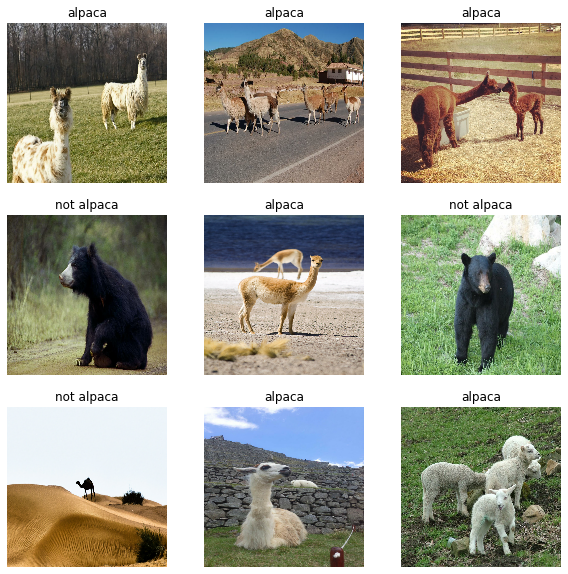

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocess and Augment Training Data

Using `prefetch()` helps avoid a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed by creating a source dataset from the input data, applying a transformation to preprocess it, and then iterating over the dataset one element at a time. Since the iteration is streaming, the data doesn't need to fit into memory.

The number of elements to prefetch can be set manually or by using `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to dynamically tune that value at runtime by tracking the time spent in each operation and feeding those times into an optimization algorithm. This algorithm tries to find the best allocation of its CPU budget across all tunable operations.

To increase diversity in the training set and help the model learn the data better, it is standard practice to augment the images by transforming them, such as randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations with built-in, customizable preprocessing layers. These layers are saved with the rest of the model and can be reused later.

For more information, refer to the official documentation on data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### data_augmenter

In [5]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [6]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


Examine how an image from the training set has been augmented with simple transformations.

One original image has been transformed into 9 variations.

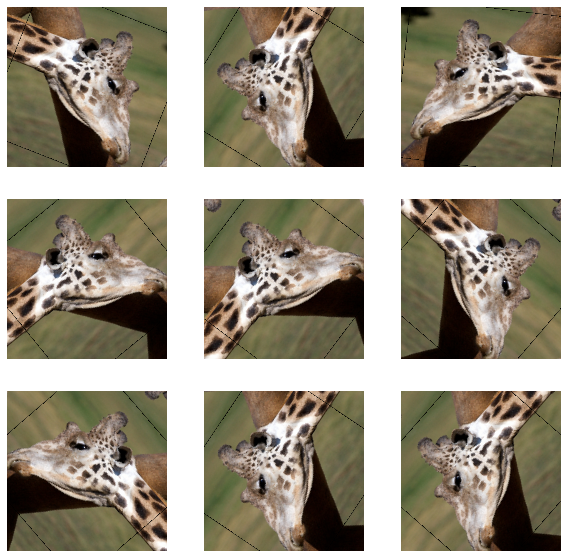

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

**Key Points:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Using MobileNetV2 for Transfer Learning

MobileNetV2, trained on ImageNet, is optimized for mobile and low-power applications. With 155 layers deep, it is highly efficient for object detection, image segmentation, and classification tasks. The architecture features three key characteristics:

* Depthwise separable convolutions
* Thin input and output bottlenecks between layers
* Shortcut connections between bottleneck layers

### Convolutional Building Block of MobileNetV2 

MobileNetV2 employs depthwise separable convolutions as efficient building blocks. Traditional convolutions can be resource-intensive, but depthwise separable convolutions reduce the number of trainable parameters and operations by speeding up convolutions in two steps:

1. The first step involves depthwise convolution, which processes each channel independently to produce an intermediate result.

2. The second step uses pointwise convolution to merge the outputs from the previous step into a single result. This involves applying a convolution across all filters in the output layer, effectively combining the intermediate results from the depthwise convolution. This process can be summarized as: **Shape of the depthwise convolution × Number of filters.**

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <u> <font> <b>Figure 1</b> </u><font>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Each block features an inverted residual structure with a bottleneck at each end. These bottlenecks encode intermediate inputs and outputs in a lower-dimensional space, helping to preserve important information by preventing non-linearities from disrupting it.

Shortcut connections, similar to those in traditional residual networks, enhance training speed and prediction accuracy. These connections bypass the intermediate convolutions and directly link the bottleneck layers.


Train the base model using all the layers from the pretrained model.

Just as the pretrained normalization values from MobileNetV2 were reused, load the pretrained weights from ImageNet by specifying `weights='imagenet'`.


In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


Print the model summary below to see all the model's layers, the shapes of their outputs, and the total number of parameters, trainable and non-trainable. 

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Observe the layers in the summary, such as `Conv2D` and `DepthwiseConv2D`, and note their progression from expansion to depthwise convolution to projection. Together with BatchNormalization and ReLU, these layers constitute the bottleneck layers described earlier.

**Key Points**:

* MobileNetV2's unique features are: 
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

Next, select the first batch from the TensorFlow dataset and pass it through the MobileNetV2 base model to test predictions on some of the images.

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [12]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

Decode the predictions made by the model. Previously, the shape of the batch printed would have been (32, 1000), where 32 represents the batch size and 1000 corresponds to the number of classes the model was pretrained on. The predictions returned by the base model follow this format:

First, the class number, followed by a human-readable label, and finally, the probability of the image belonging to that class. Each image in the batch will have two predictions, representing the top two probabilities for that image.


In [15]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n02489166', 'proboscis_monkey', 0.10329965),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883611)],
 [('n02125311', 'cougar', 0.1654676), ('n02389026', 'sorrel', 0.10764261)],
 [('n02437312', 'Arabian_camel', 0.2923283),
  ('n02437616', 'llama', 0.27713484)],
 [('n03944341', 'pinwheel', 0.31154886), ('n03047690', 'clog', 0.052500293)],
 [('n02454379', 'armadillo', 0.73107153),
  ('n01990800', 'isopod', 0.038719974)],
 [('n02437312', 'Arabian_camel', 0.25663644),
  ('n02422106', 'hartebeest', 0.12122728)],
 [('n02437616', 'llama', 0.6612557),
  ('n02090721', 'Irish_wolfhound', 0.23782855)],
 [('n02133161', 'American_black_bear', 0.82735676),
  ('n02134418', 'sloth_bear', 0.02925945)],
 [('n01518878', 'ostrich', 0.9267562),
  ('n02002724', 'black_stork', 0.0017766367)],
 [('n01518878', 'ostrich', 0.94954586),
  ('n02018795', 'bustard', 0.0028661634)],
 [('n02437616', 'llama', 0.8699833), ('n02412080', 'ram', 0.076757126)],
 [('n02415577', 'bighorn', 0.2429446), ('n02412080', 'ram', 

It appears that none of the labels include "alpaca," and some of the labels are incorrectly classified.

This happens because MobileNet, pretrained on ImageNet, does not include labels for alpacas. Consequently, using the full model results in a range of incorrect classifications.

Fortunately, it is possible to remove the top layer, which contains the classification labels, and replace it with a new classification layer.

### Layer Freezing with the Functional API

To modify the classifier task of a pretrained model to recognize alpacas, follow these three steps:

1. **Remove the Top Layer**  
    * Set `include_top` to `False` in `base_model`.

2. **Add a New Classifier Layer**  
    * Train only the new classifier layer by freezing the rest of the network.
    * A single neuron is sufficient for binary classification tasks.

3. **Freeze the Base Model and Train the New Classifier Layer**  
    * Set `base_model.trainable = False` to prevent changes to the weights and train only the new classifier layer.
    * Ensure training is disabled for `base_model` by setting it to `False` to avoid updating statistics in the batch normalization layers.


<a name='ex-2'></a>
### Exercise 2 - alpaca_model

In [18]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights="imagenet") # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create your new model using the data_augmentation function defined earlier.

In [19]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [20]:
from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)
    

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


In [21]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 9s 967ms/step - loss: 0.8003 - accuracy: 0.5153 - val_loss: 0.7219 - val_accuracy: 0.5077
Epoch 2/5
9/9 [==============================] - 7s 823ms/step - loss: 0.6549 - accuracy: 0.6107 - val_loss: 0.5317 - val_accuracy: 0.6769
Epoch 3/5
9/9 [==============================] - 7s 823ms/step - loss: 0.6254 - accuracy: 0.6985 - val_loss: 0.4445 - val_accuracy: 0.7846
Epoch 4/5
9/9 [==============================] - 7s 801ms/step - loss: 0.5338 - accuracy: 0.6718 - val_loss: 0.4847 - val_accuracy: 0.6462
Epoch 5/5
9/9 [==============================] - 7s 791ms/step - loss: 0.4952 - accuracy: 0.7328 - val_loss: 0.3715 - val_accuracy: 0.8308


Plot the training and validation accuracy:

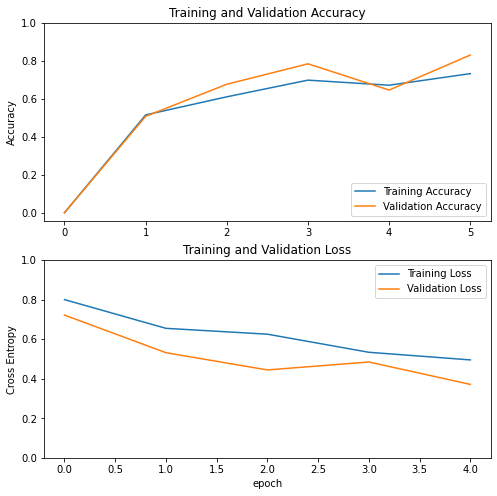

In [23]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
class_names

['alpaca', 'not alpaca']

### Fine-tuning the Model

To enhance model accuracy, fine-tuning can be performed by re-running the optimizer on the last layers. Using a smaller learning rate allows the model to make finer adjustments to the new data. In transfer learning, this involves unfreezing the layers towards the end of the network and retraining them with a very low learning rate. This approach helps capture more detailed features and improve accuracy.

**Intuition Behind Fine-Tuning:**  
Early layers of the network typically learn low-level features, such as edges, while later layers capture more complex, high-level features, like specific textures or shapes. For transfer learning, low-level features are generally kept unchanged as they apply to most images. However, high-level features should adapt to new data, allowing the network to better recognize features relevant to the specific task, such as distinguishing between different textures.

To implement fine-tuning:
1. Unfreeze the final layers of the model by setting `base_model.trainable = True`.
2. Choose a layer to start fine-tuning from and re-freeze all previous layers.
3. Re-train the model for a few additional epochs with a reduced learning rate.

The choice of where to start fine-tuning can be adjusted as needed. The key is to allow the later layers to refine their understanding of features specific to the new task, improving overall model performance.


In [25]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate * 0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [26]:
assert type(loss_function) == tf.python.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')


All tests passed!


In [27]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.6758 - accuracy: 0.6641 - val_loss: 0.3878 - val_accuracy: 0.8615
Epoch 6/10
9/9 [==============================] - 9s 988ms/step - loss: 0.4420 - accuracy: 0.7595 - val_loss: 0.2454 - val_accuracy: 0.8769
Epoch 7/10
9/9 [==============================] - 9s 978ms/step - loss: 0.3515 - accuracy: 0.8588 - val_loss: 0.2490 - val_accuracy: 0.8615
Epoch 8/10
9/9 [==============================] - 9s 982ms/step - loss: 0.2482 - accuracy: 0.9122 - val_loss: 0.1367 - val_accuracy: 0.9385
Epoch 9/10
9/9 [==============================] - 9s 980ms/step - loss: 0.1969 - accuracy: 0.9122 - val_loss: 0.0963 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 9s 956ms/step - loss: 0.1536 - accuracy: 0.9351 - val_loss: 0.1587 - val_accuracy: 0.8923


The improvement is substantial; even a small amount of fine-tuning can make a significant difference.

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

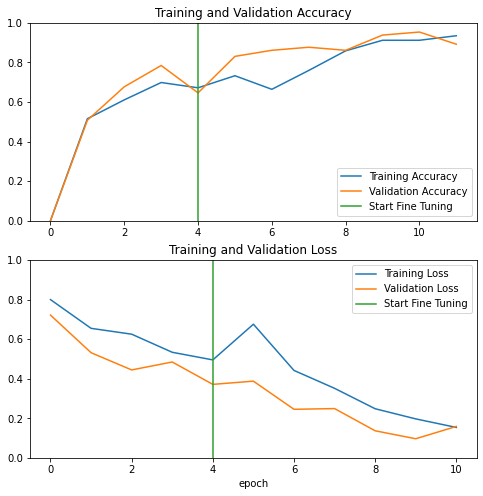

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Recap**:

* Adapt the classifier to new data by removing the top layer, adding a new classification layer, and training only that layer.
* When freezing layers, ensure that statistics tracking (such as in batch normalization layers) is disabled.
* Fine-tune the final layers of the model to capture high-level details and potentially enhance accuracy.
